<a href="https://colab.research.google.com/github/fredriklilja/stats/blob/main/CIF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Demonstration of the Cumulative Incidence Function

Author: <a href='http://www.github.com/fredriklilja/'>Fredrik Lilja</a>

The cumulative incidence function, CIF($t$), gives the probability of the event $c$ has occured at time $t$, in the precence of competing risk. The definition of CIF is:
$$ CIF(t) = \sum _{t=1} ^{t} S(t-1) * \frac{m_{c, t}}{n_{t}}$$
where $m_{c, t}$ is the number of events of interest $c$ at that time $t$, and $n_{t}$ is the number at risk at time $t$.

In the absence of competing risks CIF is equal to 1 - KM (Kaplan Meier Estimate).

This <a href='https://www.publichealth.columbia.edu/research/population-health-methods/competing-risk-analysis'> article</a> from Columbia University provides more background.

## Professor Wanhainen's HIV-example

In this example we compare patients who has been infected with HIV from blood transfusions and drug injection, respectively. The later group is assumed to have a higher death rate due to exposure to street violence. The distribution of times from HIV infection to AIDS development is assumed to be equal between groups.

The question is: if we compare these groups using Kaplan Meier and treat death as censoring. Will there be a difference in the estimation of cumulative incidence of AIDS?

We'll test that by creating some fake data.

In [1234]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

try:
  from lifelines import KaplanMeierFitter
  from lifelines import AalenJohansenFitter
except:
  !pip install lifelines
  from lifelines import KaplanMeierFitter
  from lifelines import AalenJohansenFitter

warnings.filterwarnings('ignore')

%config InlineBackend.figure_formats = ['retina']

In [1235]:
N = 1000
grp = np.random.binomial(1, 0.5, size=N)
lam_death = 0.02 * np.exp(0.7 * grp)
lam_aids = 1 / 36 # Mean time to aids is 36 months

t_death = np.random.exponential(scale=1/lam_death, size=N).astype(int)
t_aids = np.random.exponential(scale=1/lam_aids, size=N).astype(int)

max_event_time = np.maximum(t_death.max(), t_aids.max())
t_cens = np.random.uniform(0, max_event_time, size=N).astype(int)

t = np.vstack([t_cens, t_aids, t_death]).min(axis=0)

event_type = np.argmin(np.vstack([t_cens, t_aids, t_death]), axis=0)

df = pd.DataFrame({'group': grp,
                   't': t,
                   'event_type': event_type,
                   'death_time': t_death})

df.head()



,group,t,event_type,death_time
0,0,32,1,63
1,1,7,2,7
2,0,21,1,48
3,1,18,2,18
4,1,17,1,28


In [1236]:
# @title
# Define a function that does a Kaplan-Meier estimation of the survival function

def km_surv(times, events):

  '''
  A function that takes time_to event and events and returns a
  Kaplam-Meier estimate. Can only handle discrete times. Only for demostration
  purposes and should not be used in scientific calculations.
  '''

  n_subjects = len(times)

  periods = np.arange(times.max() + 1)
  last_period = times.max()

  events_mtx = np.zeros((n_subjects, last_period+1))
  events_mtx[np.arange(n_subjects), times] = events

  at_risk_mtx = np.greater_equal.outer(times, periods)

  events = events_mtx.sum(axis=0)
  at_risk = at_risk_mtx.sum(axis=0)

  surv_p = (1 - events / at_risk).cumprod()
  return surv_p

We now examine any differences in survival times without censoring between the injection and transfusion cohort.

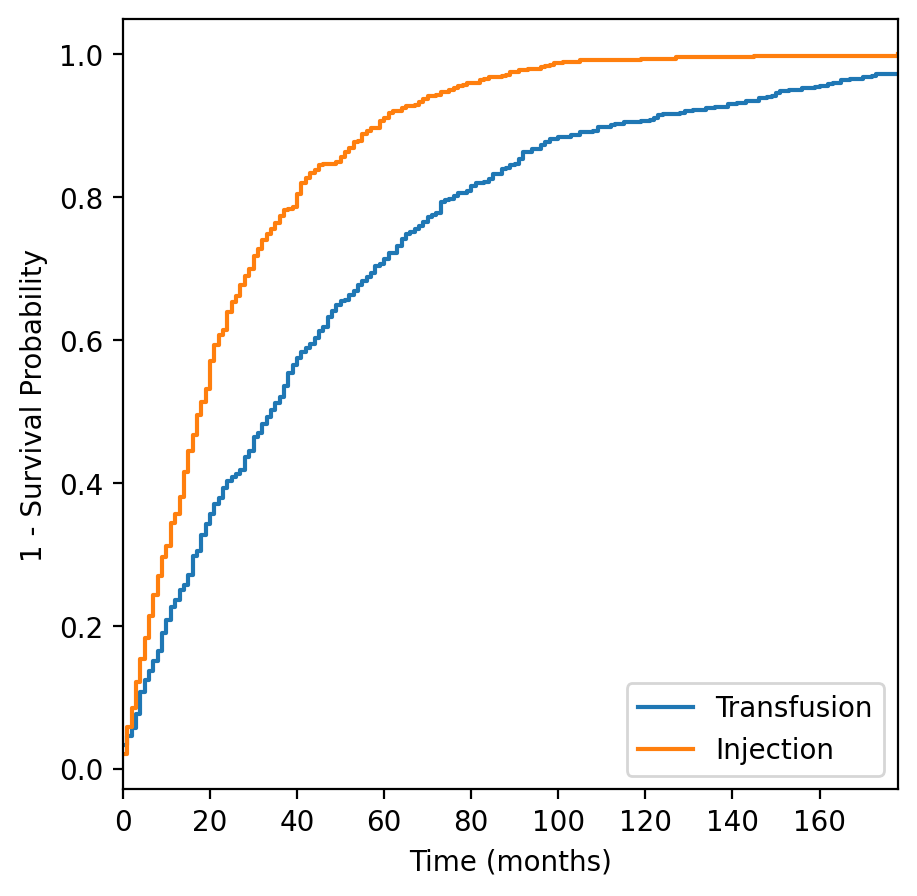

In [1237]:
# @title
# Find t and e for transfusion patients
tx_time = df.loc[df['group'] == 0 , 'death_time'].to_numpy()
tx_event = np.ones(len(tx_time))

# Fit a KM-estimate for transfusion patients
tx_surv = km_surv(tx_time, tx_event)

# Find t and e for injection patients
inj_time = df.loc[df['group'] == 1 , 'death_time'].to_numpy()
inj_event = np.ones(len(inj_time))



# Fit a KM-estimate for injection patients
inj_surv = km_surv(inj_time, inj_event)

# Make a plot
max_displ_time = np.minimum(tx_time.max(), inj_time.max())

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.step(np.arange(len(tx_surv)), 1-tx_surv, label='Transfusion', where='post')
ax.step(np.arange(len(inj_surv)), 1-inj_surv, label='Injection', where='post')

ax.set_xlim(0, max_displ_time)
ax.set_xlabel('Time (months)')
ax.set_ylabel('1 - Survival Probability')

ax.legend()
plt.show()

It is clear from the figure that patients who got HIV from drug injection has a much higer mortality rate compared to those who got infected by transfusion.

Next, we try to estimate freedrom from AIDS using Kaplan-Meier. We treat death as cencoring.

$$ S(t) = \prod _{t=0} ^{t}(1 - \frac{m_{t}}{n_{t}})$$

where $S(t)$ is the estimated survival function which is the same as the $1 - F(t)$. $F(t)$ is the cumulative distribution function (CDF) of the times from HIV infection to AIDS development.

We treat death as cencoring, <i>i. e.</i> we do not treat death as a competing risk.

Since we know the true distribution of times from HIV to AIDS, $f(t) \sim exp(1/36)$, the probability density function of times, we also know F(x), the CDF and can compare our $1 - S(t)$ to that.

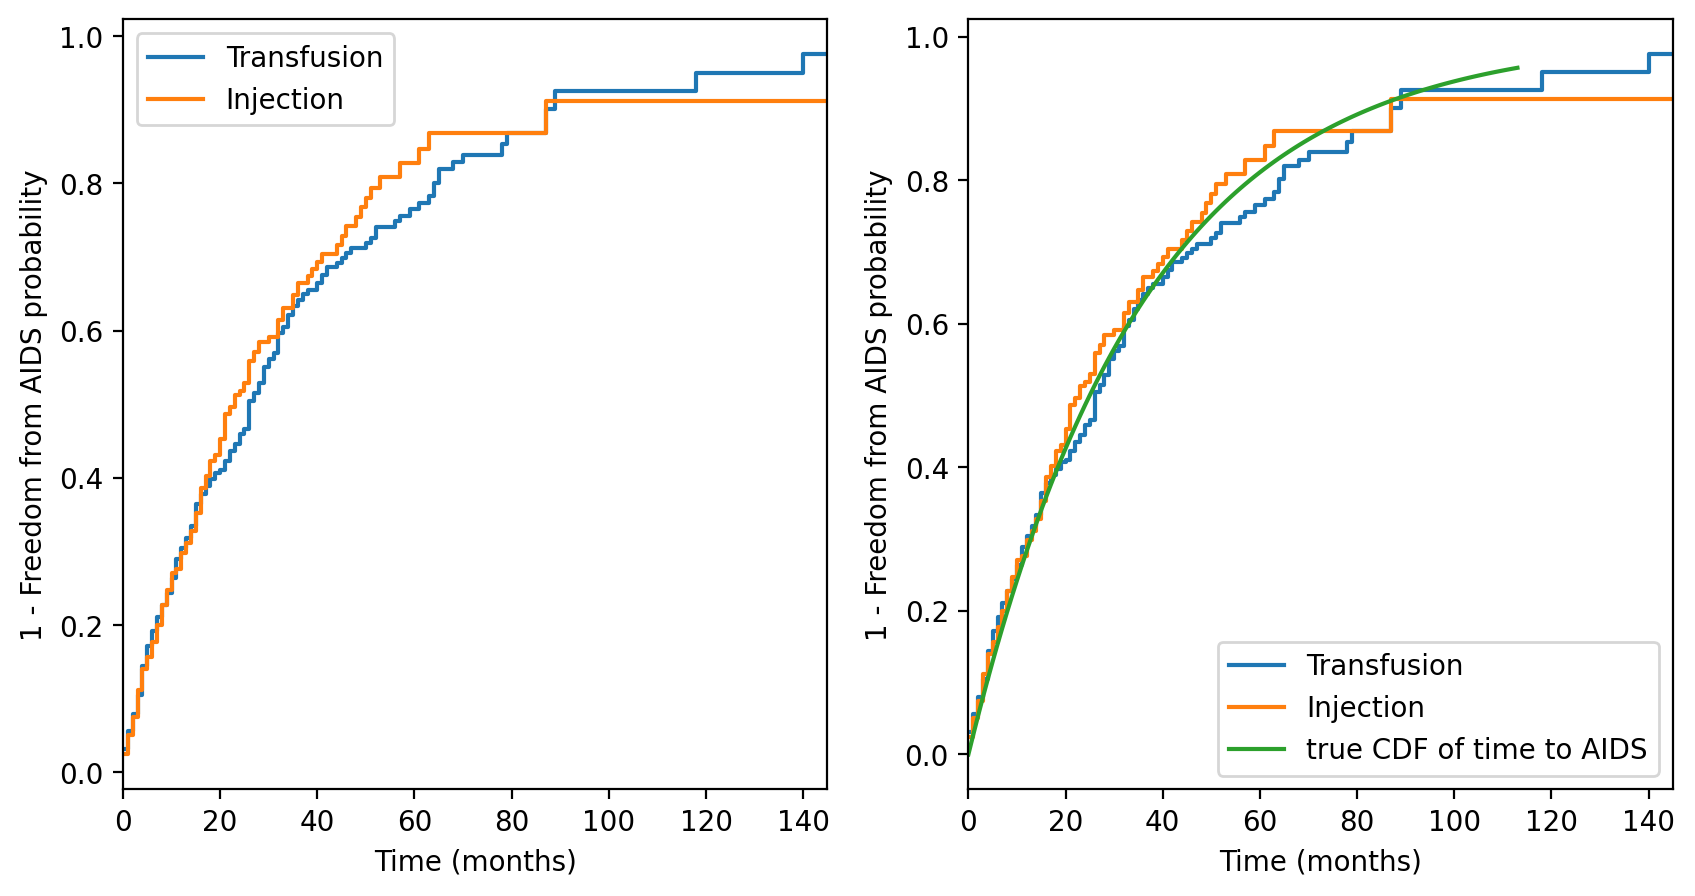

In [1238]:
# @title
tx_time = df.loc[df['group'] == 0 , 't'].to_numpy()
tx_event = df.loc[df['group'] == 0 , 'event_type'].isin([1]).astype(int).to_numpy()

tx_surv_aids = km_surv(tx_time, tx_event)

inj_time = df.loc[df['group'] == 1 , 't'].to_numpy()
inj_event = df.loc[df['group'] == 1 , 'event_type'].isin([1]).astype(int).to_numpy()

inj_surv_aids = km_surv(inj_time, inj_event)


max_displ_time = np.minimum(tx_time.max(), inj_time.max())


fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].step(np.arange(len(tx_surv_aids)), 1-tx_surv_aids, label='Transfusion', where='post')
axs[0].step(np.arange(len(inj_surv_aids)), 1-inj_surv_aids, label='Injection', where='post')

axs[1].step(np.arange(len(tx_surv_aids)), 1-tx_surv_aids, label='Transfusion', where='post')
axs[1].step(np.arange(len(inj_surv_aids)), 1-inj_surv_aids, label='Injection', where='post')

axs[1].plot(np.arange(t_max), expon.cdf(np.arange(t_max), loc=0, scale=1/lam_aids), label='true CDF of time to AIDS')

axs[0].set_xlim(0, max_displ_time)
axs[0].set_xlabel('Time (months)')
axs[0].set_ylabel('1 - Freedom from AIDS probability')

axs[1].set_xlim(0, max_displ_time)
axs[1].set_xlabel('Time (months)')
axs[1].set_ylabel('1 - Freedom from AIDS probability')

axs[0].legend()
axs[1].legend()
plt.show()

It seams as KM does a good job of estimating the true underlying distribution of times from HIV infection to AIDS development. We knew from before that $S(t)$ would be similar in both groups and that $1 - S(t)$ should be similar to $F(t)$.

But in reality it seams unreasonable that a iv drug user has the same probability of AIDS development at 100 months as somene infected by transfusion. The drug addict is more likely dead from something else (over dose, violence etc.).

So to answer the question: what is the probability of AIDS development in an iv drug user in $X$ months, we have to treat death as a competing risk.

In [1239]:
def cum_ins(times, event_type):
  '''
  Function to approximate the CIF. event 0 is cens, 1 is event of interest and
  2 is competing risk event. Only for domostration. Do not use for research.
  For thet the Aalen-Johansen class in python lifelines is strongly recommended.
  '''

  # Make an at risk matrix with n_subjects rows and n_periods + 1 columns
  n_subjects = len(times)
  n_periods = times.max() + 1
  periods = np.arange(n_periods)

  at_risk_mtx = np.greater_equal.outer(times, periods).astype(int)

  # Make a event matrix which is 1 if the event of interest
  # occured in the time period

  event = (event_type == 1).astype(int)
  event_mtx = np.zeros((n_subjects, n_periods))
  event_mtx[np.arange(n_subjects), times] = event

  # Make a matrix in which each position is 1 if any event
  # occured in the time period

  combined_event = event_type.isin([1, 2]).astype(int)
  survival_mtx = np.zeros((n_subjects, n_periods))
  survival_mtx[np.arange(n_subjects), times] = combined_event

  # Estimate the overall survial probability
  surv_prob = (1 - survival_mtx.sum(axis=0) / at_risk_mtx.sum(axis=0)).cumprod()

  # Estimate the probability of the event of interest
  event_prob = (1 - event_mtx.sum(axis=0) / at_risk_mtx.sum(axis=0)).cumprod()

  # Roll S(t) one position to the right
  rolled_surv_prob = np.roll(surv_prob, 1)
  rolled_surv_prob[0] = 1

  # Calculate event specific hazard at each t
  event_haz = event_mtx.sum(axis=0) / at_risk_mtx.sum(axis=0)

  # Create the CIF
  cum_ins = (rolled_surv_prob * event_haz).cumsum()

  return 1 - event_prob, cum_ins

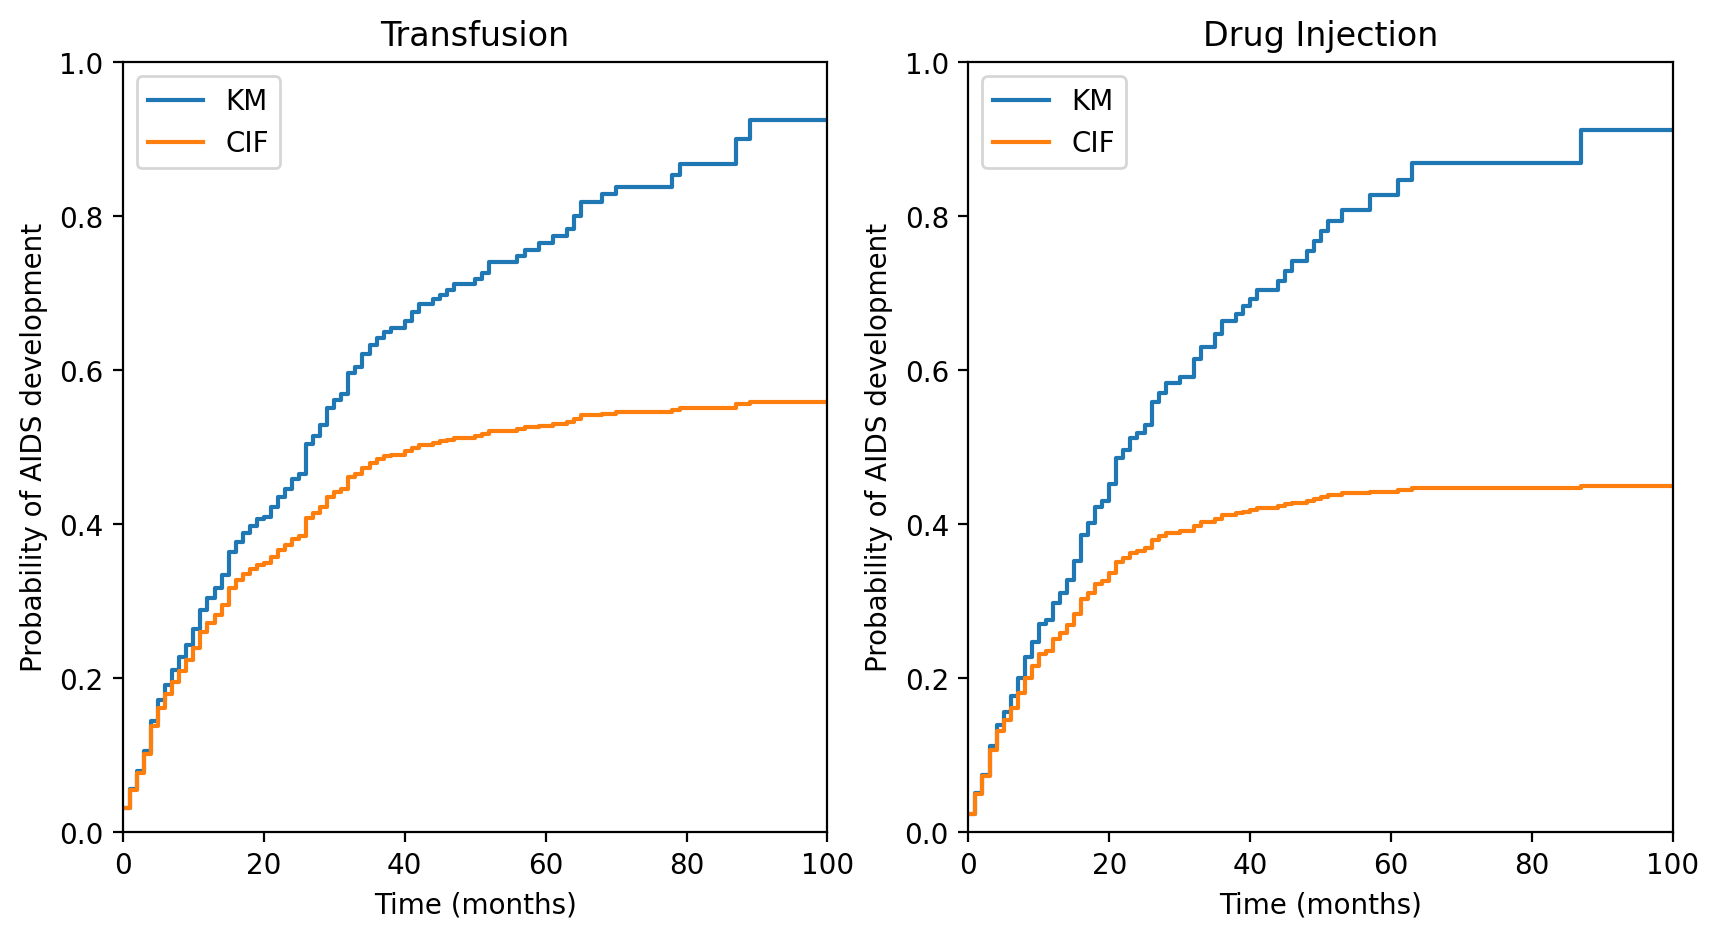

In [1240]:
# @title
tx_comp_times = df.loc[df['group'] == 0 , 't'].to_numpy()
tx_comp_event = df.loc[df['group'] == 0 , 'event_type']



inj_comp_times = df.loc[df['group'] == 1 , 't'].to_numpy()
inj_comp_event = df.loc[df['group'] == 1 , 'event_type']

tx_comp_km, tx_comp_cif = cum_ins(tx_comp_times, tx_comp_event)
inj_comp_km, inj_comp_cif = cum_ins(inj_comp_times, inj_comp_event)

fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharex=True)

axs[0].step(np.arange(len(tx_comp_km)), tx_comp_km, label='KM', where='post')
axs[0].step(np.arange(len(tx_comp_cif)), tx_comp_cif, label='CIF', where='post')

axs[1].step(np.arange(len(inj_comp_km)), inj_comp_km, label='KM', where='post')
axs[1].step(np.arange(len(inj_comp_cif)), inj_comp_cif, label='CIF', where='post')

#axs[1].step(np.arange(len(tx_surv_aids)), 1-tx_surv_aids, label='Transfusion', where='post')
#axs[1].step(np.arange(len(inj_surv_aids)), 1-inj_surv_aids, label='Injection', where='post')

#axs[1].plot(np.arange(t_max), expon.cdf(np.arange(t_max), loc=0, scale=1/lam_aids), label='true CDF of time to AIDS')

axs[0].set_title('Transfusion')
axs[0].set_xlim(0, 100)
axs[0].set_ylim(0, 1)
axs[0].set_xlabel('Time (months)')
axs[0].set_ylabel('Probability of AIDS development')

axs[1].set_title('Drug Injection')
axs[1].set_xlim(0, 100)
axs[1].set_ylim(0, 1)
axs[1].set_xlabel('Time (months)')
axs[1].set_ylabel('Probability of AIDS development')

axs[0].legend()
axs[1].legend()
plt.show()


In the presence of competing risk KM over estimates the probability of AIDS development by alot. And more so if the competing risk is bigger.

This could be understood agaist the background of CIF $ CIF(t) = \sum _{t=1} ^{t} S(t-1) * \frac{m_{c, t}}{n_{t}}$.

If the backgroud mortality rate is high $S(t)$ will be low, thus making the impact of the CIF of each new occurence of the event of interest lower.

Below is the same analysis done with the python package <a href='https://lifelines.readthedocs.io/en/latest/'>lifelines</a> just to make sure that my own functions produce similar results.



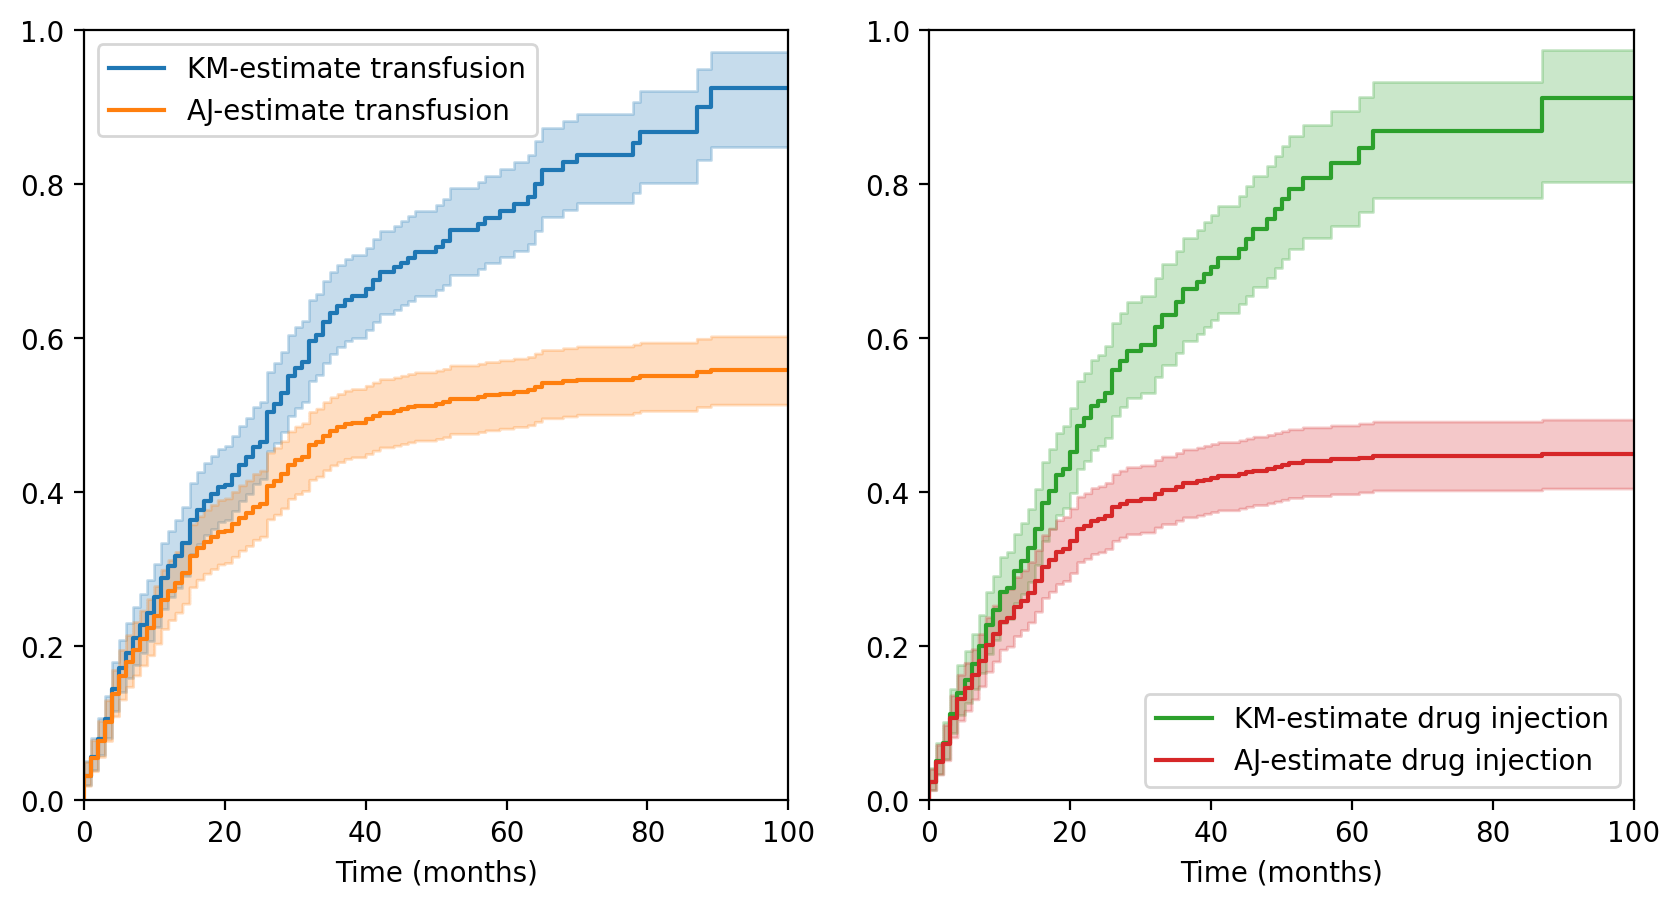

In [1241]:
# @title
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

t = df.loc[df['group'] == 0, 't'].to_numpy()
e = df.loc[df['group'] == 0, 'event_type'].isin([1]).astype(int).to_numpy()

kmf=KaplanMeierFitter()
kmf.fit(t, event_observed=e)
kmf.plot_cumulative_density(color='C0', ci_show=True, label='KM-estimate transfusion', ax=axs[0])

ajf = AalenJohansenFitter()
ajf.fit(t, df.loc[df['group'] == 0, 'event_type'].to_numpy(), event_of_interest=1)
ajf.plot(color='C1', linestyle='-', ci_show=True, label='AJ-estimate transfusion', ax=axs[0])

t = df.loc[df['group'] == 1, 't'].to_numpy()
e = df.loc[df['group'] == 1, 'event_type'].isin([1]).astype(int).to_numpy()

kmf=KaplanMeierFitter()
kmf.fit(t, event_observed=e)
kmf.plot_cumulative_density(color='C2', ci_show=True, label='KM-estimate drug injection', ax=axs[1])

ajf = AalenJohansenFitter()
ajf.fit(df.loc[df['group'] == 1, 't'].to_numpy(), df.loc[df['group'] == 1, 'event_type'].to_numpy(), event_of_interest=1)
ajf.plot(color='C3', linestyle='-', ci_show=True, label='AJ-estimate drug injection', ax=axs[1])

for ax in axs:
  ax.set_ylim(0, 1)
  ax.set_xlim(0, 100)
  ax.set_xlabel('Time (months)')

## Conclusion

My interpretation of the above is:

The CIF answers the question: "What is the probability that the event $c$ has occuret att time $t$ in the precense of competing risk"

It does, however, not answer the question "What would the probability that the event $c$ has occured at time $t$ provided the competing risk did not exist.

If I am wrong, please let me know.

Fredrik Lilja